# Quantum Dynamics Lie Suzuki Trotter

We use a the split operator method to simulate a one dimensional wavepacket going through a gaussian potential barrier(to avoid numerical oscillations).
Our hamiltonian has the standard time independent form(natural units):
$$H = \frac{p^2}{2} + V$$
We use as starting wavefunction a gaussian wavepacket traveling to the right with momentum $p_0$. 


In [1]:
import numpy as np
import scipy.fftpack as f
import matplotlib.pyplot as plt
import matplotlib.animation as animation
%matplotlib notebook 

### Initialize

In [3]:
# params
N_t = 60000 #number of time steps
dt = 1/2.5e6 #time step size
N_x = 2 ** 11 #power of two for FFT efficiency
x_min = 0
x_max = 7

#initiate x vector
dx = (x_max - x_min) / N_x
x = np.arange(x_min,x_max, dx)
p = (np.arange(N_x)) * (2 * np.pi) / (dx * N_x)
p[N_x // 2 : N_x] -= p[N_x - 1] + (2 * np.pi / (dx * N_x)) #Allow for negative momenta (initially ignored by DFT)

#initiate gaussian wavepacket centered at x0
x0 = 3.5
sigma =0.05
p0 = 100
psi0 = 1/np.sqrt(sigma*np.sqrt(2*np.pi))*np.exp(-(x-x0)**2/(4*sigma**2) + 1j*p0*(x))

#Gaussian potential barrier
V0 = 0.9 * p0 ** 2 / 2
V = V0 *np.exp(-(x-4)**2/0.1**2) +0j

#create imaginary optical boundary for damping the wave when it has reached the boundary(to avoid periodical bc)
dx_opt = 0.25 #width of boundary
U0 = 2*V0
x_opt = x_max - dx_opt 
opt_N = (int)(N_x * ((x_max - x_min - dx_opt) / (x_max - x_min)))
V[opt_N:-1] = -1j * U0 * (x[opt_N:-1] - x_opt) / dx_opt
V[0:N_x-opt_N] = 1j * U0 * (x[0:N_x-opt_N] - dx_opt) / dx_opt







### Run program

In [4]:
# Program to step in time
psi_t = np.zeros((N_t,N_x)) +0.0j
psi_t[0,:] = psi0
V_matrix = np.exp(-1j * dt * V)
T_matrix = np.exp(-1j * dt * p ** 2 / 2)
for i in range(1,N_t):
    psi_t[i,:] = np.fft.ifft(T_matrix * np.fft.fft( V_matrix * psi_t[i-1,:]))

### Results
#### Plot of initial conditions

<IPython.core.display.Javascript object>


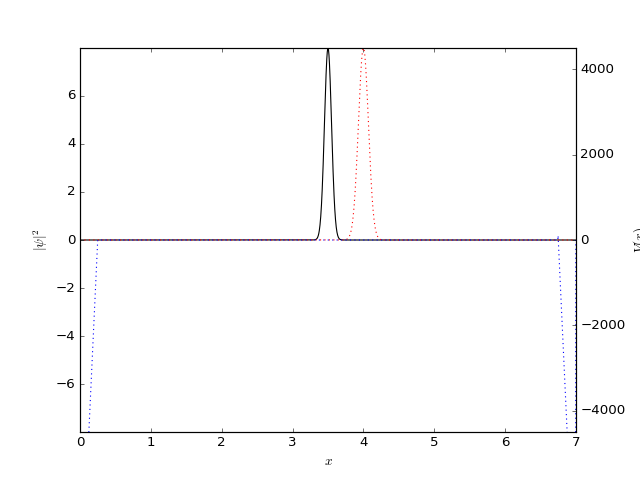

In [5]:
# Plot of the initial 
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(x, abs(psi0) ** 2,'k')
ax1.set_xlabel(r'$x$')
ax1.set_ylabel(r'$|\psi|^2$')
ax1.set_ylim(-max(abs(psi0)**2),max(abs(psi0)**2))

ax2 = ax1.twinx()
ax2.plot(x,V.real,'r:')
ax2.plot(x,V.imag,'b:')
ax2.set_ylabel(r'$V(x)$', color='k')
ax2.set_ylim(-V0,V0)
for tl in ax2.get_yticklabels():
    tl.set_color('k')
plt.show()




#### Animation of the result

<IPython.core.display.Javascript object>


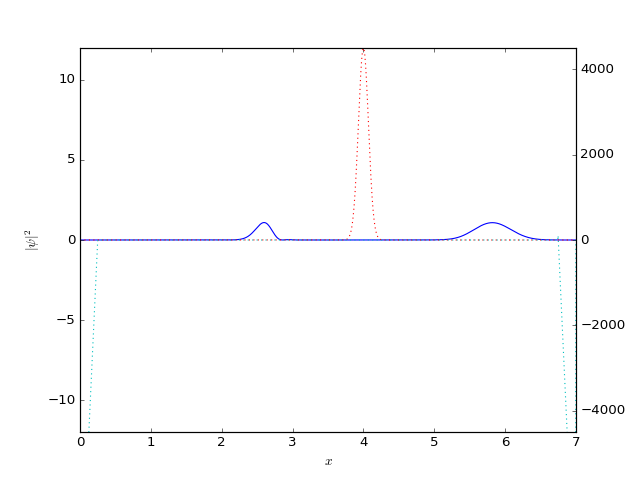

In [21]:
fig, ax = plt.subplots()
plt.xlabel(r'$x$')
plt.ylabel(r'$|\psi|^2$')
speed_factor = 100
line, = ax.plot(x, abs(psi0) ** 2)
ax2 = ax.twinx()
ax2.plot(x,V.real,'r:')
ax2.plot(x,V.imag,'c:')
ax.set_ylim((-1.5*max(abs(psi0) ** 2), 1.5*max(abs(psi0) ** 2)))
ax2.set_ylim(-V0,V0)

def animationFunc(i):
    #line.set_ydata(psi_t.real[i,:])  # update the data
    line.set_ydata(abs(psi_t[i * speed_factor,:]) **2)
    return line,

#Init only required for blitting to give a clean slate.
def init():
    line.set_ydata(np.ma.array(x, mask=True))
    return line,

ani = animation.FuncAnimation(fig, animationFunc, init_func=init, frames = (int)(N_t //speed_factor),
    interval=min(5 * speed_factor, 50), blit = True, repeat = False)
#display_animation(ani)

#### Animation of the spectral weight of the momentum over time

<IPython.core.display.Javascript object>


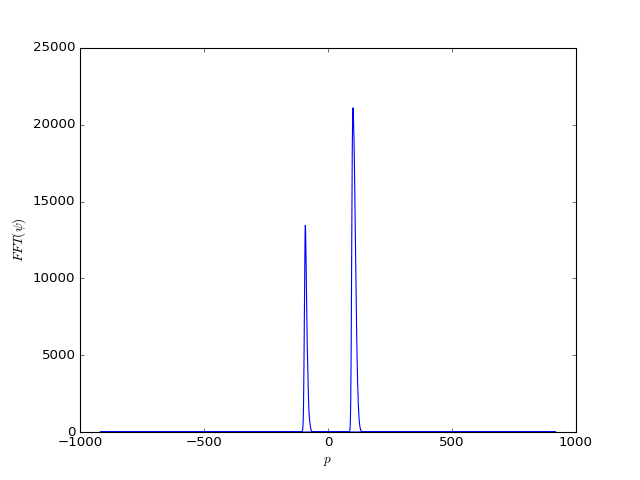

In [7]:
fig, ax = plt.subplots()
speed_factor = 150
line, = ax.plot(p, abs(np.fft.fft(psi0)) ** 2)
ax.set_xlabel(r'$p$')
ax.set_ylabel(r'$FFT(\psi)$')
def animationFunc(i):
    #line.set_ydata(psi_t.real[i,:])  # update the data
    line.set_ydata(abs((np.fft.fft(psi_t[i * speed_factor,:]))) **2)
    return line,

#Init only required for blitting to give a clean slate.
def init():
    line.set_ydata(np.ma.array(x, mask=True))
    return line,

ani = animation.FuncAnimation(fig, animationFunc, init_func=init, frames = (int)(N_t //speed_factor),
    interval=50, blit = True, repeat = False)
#display_animation(ani)

### Comments on the results
In this result we can see that the split operator method works effectively for simulating a quantum dynamic gaussian wavepacket partially reflecting through a gaussian potential barrier. It also works for a square potential, but due to the discontinuity numerical oscillations will occur there. There does seem to be less numerical oscillation than when using the Crank Nickelson method.
We corrected the momentum array properly to accord for the Discrete version of the FT and allow for the correct display of negative momentum values. We can see that there is still a maximum momentum allowed in this simulation equal to $p_{max} = \frac{\pi N_x}{L}$. If components arise with higher momentum than this, the DFT will cause it to be seen as negative momentum.
Furthermore the ratio of areas of the left and right wave tell us something about the transmission coefficient of this barrier.

In [32]:
#transmission ratio calculated in p space
psi_fft = np.fft.fft(psi_t[N_t-1,:])
Ratio_p = np.sum(abs(psi_fft[0:N_x // 2])** 2 * (2 * np.pi / (N_x * dx))) / np.sum(abs(psi_fft[N_x // 2 : N_x])** 2 * (2 * np.pi / (N_x * dx)))

In [33]:
#transmission ratio calculated in x space
Ratio_x = np.sum(abs(psi_t[N_t-1,N_x // 2 : N_x])** 2 * (2 * np.pi / (N_x * dx))) / np.sum(abs(psi_t[N_t-1,0:N_x // 2])** 2 * (2 * np.pi / (N_x * dx))) 

In [34]:
R = 1 / (1+Ratio_x)
T = Ratio_x / (1 + Ratio_x)
print("The transmission coefficient equals %.2f and reflection %.2f" % (T,R))

The transmission coefficient equals 0.69 and reflection 0.31
